In [1]:
import os

import sys
print(sys.version)

import glob
import h5py
import cv2
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Input, Flatten, Lambda, Reshape, Cropping2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import scipy.stats as stats
import PIL
from PIL import Image

import dask
import dask.array as da
from dask.distributed import Client
from dask_image.imread import imread


3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]


2025-05-06 16:49:39.181705: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 16:49:39.189009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 16:49:39.197672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 16:49:39.200176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 16:49:39.206993: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Increase the maximum image pixels limit
PIL.Image.MAX_IMAGE_PIXELS = None

# batch = 200
batch = 2

train_dir = 'train_folder'
test_dir = 'test_folder'

train_samples = len(glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True))
test_samples = len(glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True))

print(f"Training samples: {train_samples}")
print(f"Testing samples: {test_samples}")

# img_height, img_width = 15216, 21397 # Resize to smaller dimensions
# img_height, img_width = 512, 512 # Resize to smaller dimensions
# img_height, img_width = 32, 64 # Resize to smaller dimensions
# img_height, img_width = 3044, 4280 # Resize to smaller dimensions
img_height, img_width = 1522, 2140 # Resize to smaller dimensions



num_channels = 3 # RGB

datagen = ImageDataGenerator(rescale=1./255)

# Load training set in batches
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch,
    class_mode=None,
    shuffle=True,
    seed=42)

# Load test set in batches
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch,
    class_mode=None,
    shuffle=True,
    seed=42)

# Example of loading a batch
x_train_small = next(train_generator)
x_test_small = next(test_generator)

print("Train batch shape:", x_train_small.shape)
print("Test batch shape:", x_test_small.shape)

img_shape = (img_height, img_width, num_channels)

Training samples: 186
Testing samples: 124
Found 186 images belonging to 1 classes.
Found 124 images belonging to 1 classes.
Train batch shape: (2, 1522, 2140, 3)
Test batch shape: (2, 1522, 2140, 3)


In [3]:
anomaly_dir = 'anomaly_folder'

anomaly_samples = len(glob.glob(os.path.join(anomaly_dir, '**', '*.jpg'), recursive=True))
print(f"Anomaly samples: {anomaly_samples}")

anomaly_generator = datagen.flow_from_directory(
    anomaly_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    # batch_size=99999,
    batch_size=batch,
    class_mode=None,
    shuffle=True,
    seed=42)

anomaly_data = next(anomaly_generator)
anomaly_test_data = anomaly_data.copy()

Anomaly samples: 12
Found 12 images belonging to 1 classes.


In [4]:
print(type(x_train_small))
print(type(anomaly_data))
print(len(x_train_small))
print(len(x_test_small))
print(len(anomaly_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2
2
2


x_train_small shape: (2, 1522, 2140, 3)
train_samples: 186
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0]

Few of the training data samples are:


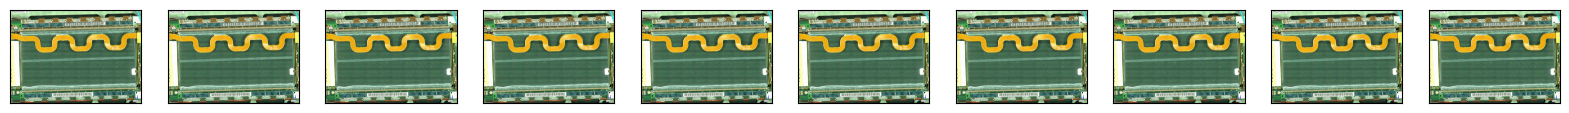

In [5]:
print("x_train_small shape:", x_train_small.shape)
print("train_samples:", train_samples)

n = []
a = 0
for j in range(0, 10):
    n.append(random.randint(0, len(x_train_small) - 1))  # Use -1 to avoid index out of range
print(n)

print('\nFew of the training data samples are:')
plt.figure(figsize=(20, 4))
for i in n:
    a = a + 1
    ax = plt.subplot(2, 10, a)
    plt.imshow(x_train_small[i])  # No reshape needed for RGB images
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [6]:
f = []
b = 0
for j in range(0, 10):
    f.append(random.randint(0, len(anomaly_data)-1))
print(f)

print('\nFew of the Anomaly data samples are:')
plt.figure(figsize=(20, 4))
             
for i in f:
    b = b + 1
    ax = plt.subplot(2, 10, b)
    plt.imshow(anomaly_data[i])  # No reshape needed for RGB images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[1, 1, 1, 0, 1, 0, 1, 0, 1, 0]

Few of the Anomaly data samples are:


In [7]:
input_img = keras.Input(shape = img_shape)

x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(encoded)
# x = keras.layers.UpSampling2D((2, 2))(x)
# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.UpSampling2D((2, 2))(x)
# x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
# x = keras.layers.UpSampling2D((2, 2))(x)
# decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
# decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
x = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Cropping2D(((0,6), (0,4)))(x)  # Trim 6 rows and 4 columns

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Evaluation model where output is the loss
loss_layer = Lambda(lambda x: K.mean(K.square(x[0] - x[1])), name='loss_layer', output_shape=lambda s: s[0])
# Define the model
model_evalloss = Model(inputs=[input_img, input_img], outputs=loss_layer([input_img, decoded]))
# model_evalloss.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_evalloss.summary()


I0000 00:00:1746542994.587137 1440750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746542994.604361 1440750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746542994.606369 1440750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746542994.608840 1440750 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1522, 2140, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1522, 2140, 10) │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 761, 1070, 10)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 761, 1070, 10)  │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 381, 535, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 381, 535, 8)    │           728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 191, 268, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 191, 268, 10)   │           730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 382, 536, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 382, 536, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 764, 1072, 10)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 764, 1072, 16)  │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 1528, 2144, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1528, 2144, 3)  │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 1522, 2140, 3)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,449 (21.29 KB)

 Trainable params: 5,449 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1522,      │          0 │ -                 │
│ (InputLayer)        │ 2140, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1522,      │        280 │ input_layer[0][0] │
│                     │ 2140, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 761, 1070, │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 761, 1070, │        910 │ max_pooling2d[0]… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 381, 535,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 381, 535,  │        728 │ max_pooling2d_1[… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 191, 268,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 191, 268,  │        730 │ max_pooling2d_2[… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 382, 536,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 382, 536,  │        910 │ up_sampling2d[0]… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 764, 1072, │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 764, 1072, │      1,456 │ up_sampling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 1528,      │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 2144, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 1528,      │        435 │ up_sampling2d_2[… │
│                     │ 2144, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 1522,      │          0 │ conv2d_6[0][0]    │
│ (Cropping2D)        │ 2140, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loss_layer (Lambda) │ (None, 1522,      │          0 │ input_layer[0][0… │
│                     │ 2140, 3)          │            │ cropping2d[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,449 (21.29 KB)

 Trainable params: 5,449 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# x_train_small = x_train_small.astype('float16')/255.0
# x_test_small = x_test_small.astype('float16')/255.0

# # Example: Resize each image in the dataset to 128x128
# x_train_small_resized = np.array([np.array(Image.open(img).resize((128, 128))) for img in x_train_small])
# x_test_small_resized = np.array([np.array(Image.open(img).resize((128, 128))) for img in x_test_small])


# print(f"Training data size (GB): {x_train_small.nbytes / (1024**3):.2f} GB")
# print("Shape:", x_train_small.shape)

# print(f"Testing data size (GB): {x_test_small.nbytes / (1024**3):.2f} GB")
# print("Shape:", x_test_small.shape)

# print(tf.config.list_physical_devices('GPU'))

# gpu_devices = tf.config.list_physical_devices('GPU')  # Non-experimental method
# for device in gpu_devices:
#     print(tf.config.experimental.get_memory_info("GPU:0"))  # Use "GPU:0" directly


def data_generator(x_data, batch_size):
    while True:  # For infinite training
        for i in range(0, len(x_data), batch_size):
            x_batch = x_data[i:i+batch_size]
            yield x_batch, x_batch  # for autoencoder: input = target

# batch = 1  # or 2, depending on memory
train_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(x_train_small, batch),
    output_signature=(
        tf.TensorSpec(shape=(None, 1522, 2140, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1522, 2140, 3), dtype=tf.float32),
    )
)

val_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(x_test_small, batch),
    output_signature=(
        tf.TensorSpec(shape=(None, 1522, 2140, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1522, 2140, 3), dtype=tf.float32),
    )
)

a = autoencoder.fit(
    train_gen,
    # epochs=25,
    epochs=20000,
    steps_per_epoch=len(x_train_small) // batch,
    validation_data=val_gen,
    validation_steps=len(x_test_small) // batch,
    # callbacks=[GPUMemoryCallback()]
)

Epoch 1/20000


I0000 00:00:1746542995.971461 1440997 service.cc:146] XLA service 0x7fe8b400d670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746542995.971490 1440997 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-05-06 16:49:55.998157: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-06 16:49:56.113187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
E0000 00:00:1746542996.931879 1440997 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746542997.054506 1440997 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 0.0841

I0000 00:00:1746543008.195261 1440997 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1746543009.065521 1441000 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746543009.187312 1441000 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746543009.535572 1441000 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746543009.626116 1441000 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746543010.218586 1441000 gpu_timer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.0841 - val_loss: 0.0849
Epoch 2/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0838 - val_loss: 0.0847
Epoch 3/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0836 - val_loss: 0.0844
Epoch 4/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0833 - val_loss: 0.0841
Epoch 5/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0830 - val_loss: 0.0838
Epoch 6/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0827 - val_loss: 0.0834
Epoch 7/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0823 - val_loss: 0.0829
Epoch 8/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0818 - val_loss: 0.0824
Epoch 9/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0813 - val_loss: 0.0819
Epoch 10/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0808 - val_loss: 0.0813
Epoch 11/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0802 - val_loss: 0.0807
Epoch 12/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - 

2025-05-06 17:01:22.629885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4062/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4063/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4064/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4065/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4066/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4067/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 4068/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 4069/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 4070/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 4071/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4072/20000
1/1 ━━━━━━

2025-05-06 17:01:24.783588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:01:24.948861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4075/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4076/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4077/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4078/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4079/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4080/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4081/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4082/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4083/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4084/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4085/20000
1/1 ━━━━━━

2025-05-06 17:01:27.111382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:01:27.278132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4089/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4090/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4091/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4092/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4093/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4094/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4095/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4096/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4097/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4098/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4099/20000
1/1 ━━━━━━

2025-05-06 17:01:29.604086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4104/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4105/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4106/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4107/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4108/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4109/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4110/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4111/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4112/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4113/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 4114/20000
1/1 ━━━━━━

2025-05-06 17:01:31.755141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:01:31.922915: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 4117/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4118/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4119/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4120/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4121/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4122/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4123/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4124/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4125/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4126/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4127/20000
1/1 ━━━━━━

2025-05-06 17:01:34.241206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4132/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4133/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4134/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4135/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4136/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4137/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4138/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4139/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4140/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4141/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4142/20000
1/1 ━━━━━━

2025-05-06 17:01:36.393797: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:01:36.559731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4145/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4146/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4147/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4148/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4149/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4150/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4151/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4152/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4153/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4154/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4155/20000
1/1 ━━━━━━

2025-05-06 17:01:38.868544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4160/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 4161/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 4162/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0138 - val_loss: 0.0148
Epoch 4163/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 4164/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 4165/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4166/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4167/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4168/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4169/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 4170/20000
1/1 ━━━━━━

2025-05-06 17:01:43.172078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4186/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4187/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4188/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4189/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4190/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4191/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4192/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4193/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4194/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4195/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4196/20000
1/1 ━━━━━━

2025-05-06 17:01:45.487413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4200/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4201/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4202/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4203/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4204/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4205/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4206/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4207/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4208/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4209/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4210/20000
1/1 ━━━━━━

2025-05-06 17:01:49.796082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4226/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4227/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4228/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4229/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4230/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4231/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4232/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4233/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4234/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4235/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4236/20000
1/1 ━━━━━━

2025-05-06 17:01:54.436822: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4254/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4255/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 4256/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4257/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4258/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4259/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4260/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4261/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4262/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4263/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4264/20000
1/1 ━━━━━━

2025-05-06 17:01:56.756264: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4268/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4269/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4270/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4271/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4272/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4273/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4274/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4275/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4276/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4277/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4278/20000
1/1 ━━━━━━

2025-05-06 17:01:59.074941: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:01:59.244456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4282/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4283/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4284/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4285/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4286/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4287/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4288/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4289/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4290/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4291/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4292/20000
1/1 ━━━━━━

2025-05-06 17:02:01.568163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4297/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4298/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4299/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4300/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4301/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4302/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4303/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4304/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4305/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4306/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4307/20000
1/1 ━━━━━━

2025-05-06 17:02:03.558762: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4309/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4310/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4311/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4312/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4313/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4314/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4315/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4316/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4317/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4318/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4319/20000
1/1 ━━━━━━

2025-05-06 17:02:05.884982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4323/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4324/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4325/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4326/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4327/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4328/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4329/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4330/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4331/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4332/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4333/20000
1/1 ━━━━━━

2025-05-06 17:02:08.206044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4337/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4338/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4339/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4340/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4341/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4342/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4343/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4344/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4345/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4346/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4347/20000
1/1 ━━━━━━

2025-05-06 17:02:10.532457: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4351/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4352/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4353/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4354/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4355/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4356/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4357/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4358/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4359/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4360/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4361/20000
1/1 ━━━━━━

2025-05-06 17:02:12.874160: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4365/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4366/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4367/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4368/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4369/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4370/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4371/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4372/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4373/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4374/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4375/20000
1/1 ━━━━━━

2025-05-06 17:02:15.194887: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4379/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4380/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4381/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4382/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4383/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4384/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4385/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4386/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4387/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4388/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4389/20000
1/1 ━━━━━━

2025-05-06 17:02:17.520966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4393/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4394/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4395/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4396/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4397/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4398/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4399/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4400/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4401/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4402/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4403/20000
1/1 ━━━━━━

2025-05-06 17:02:19.531416: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4405/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4406/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4407/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4408/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4409/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4410/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4411/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4412/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4413/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4414/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4415/20000
1/1 ━━━━━━

2025-05-06 17:02:21.536218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4417/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4418/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4419/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4420/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4421/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4422/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4423/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4424/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4425/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4426/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4427/20000
1/1 ━━━━━━

2025-05-06 17:02:23.863410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4431/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4432/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4433/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4434/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4435/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 4436/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 4437/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4438/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4439/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4440/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4441/20000
1/1 ━━━━━━

2025-05-06 17:02:28.371815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4458/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4459/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4460/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4461/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4462/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4463/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4464/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4465/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4466/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4467/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4468/20000
1/1 ━━━━━━

2025-05-06 17:02:30.473948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4471/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4472/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 4473/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4474/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4475/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4476/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4477/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4478/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4479/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4480/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4481/20000
1/1 ━━━━━━

2025-05-06 17:02:32.599816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:02:32.763235: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4483/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4484/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4485/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4486/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4487/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4488/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4489/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4490/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4491/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4492/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4493/20000
1/1 ━━━━━━

2025-05-06 17:02:34.893623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:02:35.055797: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4498/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4499/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4500/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4501/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4502/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4503/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4504/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4505/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4506/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4507/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4508/20000
1/1 ━━━━━━

2025-05-06 17:02:37.355517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4513/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4514/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4515/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4516/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4517/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4518/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4519/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4520/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4521/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4522/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4523/20000
1/1 ━━━━━━

2025-05-06 17:02:39.492698: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4526/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4527/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4528/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4529/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4530/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4531/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4532/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4533/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4534/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4535/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4536/20000
1/1 ━━━━━━

2025-05-06 17:02:41.754556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:02:41.918112: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4539/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4540/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4541/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4542/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4543/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4544/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4545/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4546/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4547/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4548/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4549/20000
1/1 ━━━━━━

2025-05-06 17:02:44.042215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4553/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4554/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4555/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4556/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4557/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4558/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4559/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4560/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4561/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4562/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4563/20000
1/1 ━━━━━━

2025-05-06 17:02:46.344034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4567/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4568/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4569/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 4570/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4571/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4572/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 4573/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4574/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4575/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4576/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4577/20000
1/1 ━━━━━━

2025-05-06 17:02:48.634304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4580/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4581/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4582/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4583/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4584/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4585/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4586/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4587/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4588/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4589/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4590/20000
1/1 ━━━━━━

2025-05-06 17:02:50.924514: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4595/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4596/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4597/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4598/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4599/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4600/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4601/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4602/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4603/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4604/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4605/20000
1/1 ━━━━━━

2025-05-06 17:02:53.216716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4609/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4610/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4611/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4612/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4613/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4614/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4615/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4616/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4617/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4618/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4619/20000
1/1 ━━━━━━

2025-05-06 17:02:55.499993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4623/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4624/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4625/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4626/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4627/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4628/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4629/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4630/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4631/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4632/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4633/20000
1/1 ━━━━━━

2025-05-06 17:02:57.786195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4636/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4637/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4638/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4639/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4640/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4641/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4642/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4643/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4644/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4645/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4646/20000
1/1 ━━━━━━

2025-05-06 17:03:00.070079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4651/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4652/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4653/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4654/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4655/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4656/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4657/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4658/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4659/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4660/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4661/20000
1/1 ━━━━━━

2025-05-06 17:03:02.044083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4663/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4664/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4665/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4666/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4667/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4668/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4669/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4670/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4671/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4672/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4673/20000
1/1 ━━━━━━

2025-05-06 17:03:04.331209: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4676/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4677/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4678/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4679/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4680/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4681/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4682/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4683/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4684/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4685/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4686/20000
1/1 ━━━━━━

2025-05-06 17:03:06.625489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4691/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4692/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4693/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4694/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4695/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4696/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4697/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4698/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4699/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4700/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4701/20000
1/1 ━━━━━━

2025-05-06 17:03:08.923231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4705/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4706/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4707/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4708/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4709/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4710/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4711/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4712/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4713/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4714/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4715/20000
1/1 ━━━━━━

2025-05-06 17:03:11.218700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4719/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4720/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4721/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4722/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4723/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4724/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4725/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4726/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4727/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4728/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4729/20000
1/1 ━━━━━━

2025-05-06 17:03:13.521087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4733/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4734/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4735/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4736/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4737/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4738/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4739/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4740/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4741/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4742/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4743/20000
1/1 ━━━━━━

2025-05-06 17:03:15.814539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4747/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4748/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4749/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4750/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4751/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4752/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4753/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4754/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4755/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4756/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4757/20000
1/1 ━━━━━━

2025-05-06 17:03:18.112604: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4761/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4762/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4763/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4764/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4765/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4766/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4767/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4768/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4769/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4770/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4771/20000
1/1 ━━━━━━

2025-05-06 17:03:22.223270: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4786/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4787/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4788/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4789/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4790/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4791/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4792/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4793/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4794/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4795/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4796/20000
1/1 ━━━━━━

2025-05-06 17:03:24.518712: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4800/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4801/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4802/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4803/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4804/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4805/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4806/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4807/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4808/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4809/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4810/20000
1/1 ━━━━━━

2025-05-06 17:03:26.813517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4814/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4815/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4816/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4817/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4818/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4819/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4820/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4821/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4822/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4823/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 4824/20000
1/1 ━━━━━━

2025-05-06 17:03:29.117299: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4828/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4829/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4830/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4831/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4832/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4833/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4834/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4835/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4836/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4837/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4838/20000
1/1 ━━━━━━

2025-05-06 17:03:31.404385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4842/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4843/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4844/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4845/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4846/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4847/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4848/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4849/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4850/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4851/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4852/20000
1/1 ━━━━━━

2025-05-06 17:03:33.688755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4855/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4856/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4857/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4858/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4859/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4860/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4861/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4862/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4863/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4864/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4865/20000
1/1 ━━━━━━

2025-05-06 17:03:35.986384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4870/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4871/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4872/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4873/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4874/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4875/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4876/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4877/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4878/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4879/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4880/20000
1/1 ━━━━━━

2025-05-06 17:03:38.270916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4884/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4885/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4886/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4887/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4888/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4889/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4890/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4891/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4892/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4893/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4894/20000
1/1 ━━━━━━

2025-05-06 17:03:40.561996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4898/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4899/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4900/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4901/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4902/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4903/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4904/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4905/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4906/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4907/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4908/20000
1/1 ━━━━━━

2025-05-06 17:03:42.863895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4912/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4913/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4914/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4915/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4916/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4917/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4918/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4919/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4920/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4921/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4922/20000
1/1 ━━━━━━

2025-05-06 17:03:45.148830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4926/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4927/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4928/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4929/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4930/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4931/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4932/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4933/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4934/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4935/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4936/20000
1/1 ━━━━━━

2025-05-06 17:03:49.414366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4951/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4952/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4953/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4954/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4955/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4956/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4957/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4958/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4959/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4960/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4961/20000
1/1 ━━━━━━

2025-05-06 17:03:51.713341: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4966/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4967/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4968/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4969/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4970/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4971/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4972/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 4973/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4974/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4975/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4976/20000
1/1 ━━━━━━

2025-05-06 17:03:53.846393: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4979/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4980/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4981/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4982/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4983/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4984/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4985/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4986/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4987/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4988/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 4989/20000
1/1 ━━━━━━

2025-05-06 17:03:55.974323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4992/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4993/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4994/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4995/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 4996/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4997/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4998/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 4999/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5000/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5001/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5002/20000
1/1 ━━━━━━

2025-05-06 17:03:58.267681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5006/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5007/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5008/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5009/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5010/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5011/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5012/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5013/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5014/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5015/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5016/20000
1/1 ━━━━━━

2025-05-06 17:04:00.556319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5020/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5021/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5022/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5023/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5024/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5025/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5026/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5027/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5028/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5029/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5030/20000
1/1 ━━━━━━

2025-05-06 17:04:05.151301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5048/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5049/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5050/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5051/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5052/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5053/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5054/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5055/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5056/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5057/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5058/20000
1/1 ━━━━━━

2025-05-06 17:04:07.448397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5061/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5062/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 5063/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5064/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5065/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5066/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5067/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5068/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5069/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5070/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5071/20000
1/1 ━━━━━━

2025-05-06 17:04:09.581744: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:04:09.750096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5075/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5076/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5077/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5078/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5079/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5080/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5081/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5082/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5083/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5084/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5085/20000
1/1 ━━━━━━

2025-05-06 17:04:12.041843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5090/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5091/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5092/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5093/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5094/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5095/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5096/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5097/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5098/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5099/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5100/20000
1/1 ━━━━━━

2025-05-06 17:04:14.332837: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5103/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5104/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5105/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5106/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5107/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 5108/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5109/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5110/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5111/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5112/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5113/20000
1/1 ━━━━━━

2025-05-06 17:04:16.624350: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5118/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 5119/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5120/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5121/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5122/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5123/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5124/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5125/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5126/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5127/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5128/20000
1/1 ━━━━━━

2025-05-06 17:04:18.937593: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5131/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5132/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5133/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5134/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5135/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5136/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5137/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5138/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5139/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5140/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5141/20000
1/1 ━━━━━━

2025-05-06 17:04:21.067350: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:04:21.234055: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5145/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5146/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5147/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5148/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5149/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5150/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5151/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5152/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5153/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5154/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5155/20000
1/1 ━━━━━━

2025-05-06 17:04:23.198308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5158/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5159/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5160/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5161/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5162/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5163/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 5164/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5165/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5166/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5167/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5168/20000
1/1 ━━━━━━

2025-05-06 17:04:25.495730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5172/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5173/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5174/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5175/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5176/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5177/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5178/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5179/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5180/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5181/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5182/20000
1/1 ━━━━━━

2025-05-06 17:04:27.628751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:04:27.793382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5185/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5186/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5187/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5188/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5189/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5190/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5191/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5192/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5193/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5194/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5195/20000
1/1 ━━━━━━

2025-05-06 17:04:29.922395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:04:30.085873: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5199/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 5200/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5201/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 5202/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5203/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5204/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5205/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5206/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5207/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5208/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5209/20000
1/1 ━━━━━━

2025-05-06 17:04:32.218436: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:04:32.383268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5213/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5214/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5215/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5216/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5217/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5218/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5219/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5220/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5221/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5222/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5223/20000
1/1 ━━━━━━

2025-05-06 17:04:36.819280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5241/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5242/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5243/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5244/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5245/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5246/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5247/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5248/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5249/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5250/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5251/20000
1/1 ━━━━━━

2025-05-06 17:04:41.086964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5267/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5268/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5269/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5270/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5271/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5272/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5273/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5274/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5275/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5276/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5277/20000
1/1 ━━━━━━

2025-05-06 17:04:45.350354: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5293/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5294/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5295/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5296/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5297/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5298/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5299/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5300/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5301/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5302/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5303/20000
1/1 ━━━━━━

2025-05-06 17:04:47.651278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5307/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5308/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5309/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5310/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5311/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5312/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5313/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5314/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5315/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5316/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5317/20000
1/1 ━━━━━━

2025-05-06 17:04:49.958970: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5321/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5322/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5323/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5324/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5325/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5326/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5327/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5328/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5329/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5330/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5331/20000
1/1 ━━━━━━

2025-05-06 17:04:54.218504: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5347/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5348/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5349/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5350/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5351/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5352/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5353/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5354/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5355/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5356/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5357/20000
1/1 ━━━━━━

2025-05-06 17:04:56.503534: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5361/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5362/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5363/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5364/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5365/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5366/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5367/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5368/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5369/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5370/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5371/20000
1/1 ━━━━━━

2025-05-06 17:04:58.798664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5375/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 5376/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5377/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5378/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5379/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5380/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5381/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5382/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5383/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5384/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5385/20000
1/1 ━━━━━━

2025-05-06 17:05:03.069664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5401/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5402/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5403/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5404/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5405/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5406/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5407/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5408/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5409/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5410/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5411/20000
1/1 ━━━━━━

2025-05-06 17:05:05.353865: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5415/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5416/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5417/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5418/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5419/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5420/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5421/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5422/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5423/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 5424/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 5425/20000
1/1 ━━━━━━

2025-05-06 17:05:07.648379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5429/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5430/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5431/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5432/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5433/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5434/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5435/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5436/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5437/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5438/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5439/20000
1/1 ━━━━━━

2025-05-06 17:05:09.945311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5443/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5444/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5445/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5446/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5447/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5448/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5449/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5450/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5451/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5452/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5453/20000
1/1 ━━━━━━

2025-05-06 17:05:12.237359: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5457/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5458/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5459/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5460/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5461/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5462/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5463/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5464/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5465/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5466/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5467/20000
1/1 ━━━━━━

2025-05-06 17:05:14.526558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5471/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5472/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5473/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5474/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5475/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5476/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5477/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5478/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5479/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5480/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5481/20000
1/1 ━━━━━━

2025-05-06 17:05:16.508651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5483/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5484/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5485/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5486/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5487/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5488/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5489/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5490/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5491/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5492/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5493/20000
1/1 ━━━━━━

2025-05-06 17:05:18.794944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5497/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5498/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5499/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5500/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5501/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5502/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5503/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5504/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5505/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5506/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5507/20000
1/1 ━━━━━━

2025-05-06 17:05:21.088762: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5511/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5512/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5513/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5514/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5515/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5516/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5517/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5518/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5519/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5520/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5521/20000
1/1 ━━━━━━

2025-05-06 17:05:23.385064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5525/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5526/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5527/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5528/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5529/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5530/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5531/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5532/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5533/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5534/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5535/20000
1/1 ━━━━━━

2025-05-06 17:05:25.676844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5539/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5540/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5541/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5542/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5543/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5544/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5545/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5546/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5547/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5548/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5549/20000
1/1 ━━━━━━

2025-05-06 17:05:27.977442: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5553/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5554/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5555/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5556/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5557/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5558/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5559/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5560/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5561/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5562/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5563/20000
1/1 ━━━━━━

2025-05-06 17:05:30.272282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5566/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5567/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5568/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5569/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5570/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5571/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5572/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5573/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5574/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5575/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5576/20000
1/1 ━━━━━━

2025-05-06 17:05:32.402670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:05:32.567496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5580/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5581/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5582/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5583/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5584/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5585/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5586/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5587/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5588/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5589/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5590/20000
1/1 ━━━━━━

2025-05-06 17:05:34.705923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5594/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5595/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5596/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5597/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5598/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5599/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5600/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 5601/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5602/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5603/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5604/20000
1/1 ━━━━━━

2025-05-06 17:05:38.987110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5620/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5621/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5622/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5623/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5624/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5625/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5626/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5627/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5628/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5629/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5630/20000
1/1 ━━━━━━

2025-05-06 17:05:41.278699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5634/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5635/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5636/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5637/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5638/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5639/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5640/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5641/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5642/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5643/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5644/20000
1/1 ━━━━━━

2025-05-06 17:05:43.581175: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 5648/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5649/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5650/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5651/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5652/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5653/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5654/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5655/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5656/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5657/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5658/20000
1/1 ━━━━━━

2025-05-06 17:05:45.870936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5661/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5662/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5663/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5664/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5665/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5666/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5667/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5668/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5669/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5670/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5671/20000
1/1 ━━━━━━

2025-05-06 17:05:48.159222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5676/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5677/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5678/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5679/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5680/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5681/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5682/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5683/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5684/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5685/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5686/20000
1/1 ━━━━━━

2025-05-06 17:05:50.459015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5690/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 5691/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5692/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5693/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5694/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5695/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5696/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5697/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5698/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5699/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5700/20000
1/1 ━━━━━━

2025-05-06 17:05:52.914031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5705/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5706/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5707/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5708/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5709/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5710/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5711/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5712/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5713/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5714/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5715/20000
1/1 ━━━━━━

2025-05-06 17:05:57.173679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:05:57.340352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5730/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5731/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5732/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5733/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5734/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5735/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5736/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5737/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5738/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5739/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5740/20000
1/1 ━━━━━━

2025-05-06 17:05:59.635002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5745/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5746/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5747/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5748/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5749/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5750/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5751/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5752/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5753/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5754/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5755/20000
1/1 ━━━━━━

2025-05-06 17:06:01.932843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5759/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5760/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5761/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5762/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5763/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5764/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5765/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5766/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5767/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5768/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5769/20000
1/1 ━━━━━━

2025-05-06 17:06:04.214435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:06:04.377867: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5774/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5775/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5776/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5777/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5778/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5779/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5780/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5781/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5782/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5783/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5784/20000
1/1 ━━━━━━

2025-05-06 17:06:06.676319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5788/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5789/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5790/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5791/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5792/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5793/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5794/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5795/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5796/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5797/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5798/20000
1/1 ━━━━━━

2025-05-06 17:06:08.979902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5803/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5804/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5805/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5806/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5807/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5808/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5809/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5810/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5811/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5812/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5813/20000
1/1 ━━━━━━

2025-05-06 17:06:11.272710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:06:11.435011: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5817/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5818/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5819/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5820/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5821/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5822/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5823/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5824/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5825/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5826/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5827/20000
1/1 ━━━━━━

2025-05-06 17:06:13.746414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5832/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5833/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5834/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5835/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5836/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5837/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5838/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5839/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5840/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 5841/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5842/20000
1/1 ━━━━━━

2025-05-06 17:06:16.201053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5847/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5848/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5849/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5850/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5851/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5852/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5853/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5854/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5855/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5856/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5857/20000
1/1 ━━━━━━

2025-05-06 17:06:18.171636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5858/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5859/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5860/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5861/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5862/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5863/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5864/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5865/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5866/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5867/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5868/20000
1/1 ━━━━━━

2025-05-06 17:06:20.471033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:06:20.633093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5872/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5873/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5874/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5875/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5876/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5877/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5878/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5879/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5880/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5881/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5882/20000
1/1 ━━━━━━

2025-05-06 17:06:22.934357: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 5888/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5889/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5890/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5891/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5892/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5893/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5894/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0139
Epoch 5895/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5896/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5897/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5898/20000
1/1 ━━━━━━

2025-05-06 17:06:25.387473: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5903/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5904/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5905/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5906/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5907/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5908/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5909/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5910/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5911/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5912/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5913/20000
1/1 ━━━━━━

2025-05-06 17:06:30.147341: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5932/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5933/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5934/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5935/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5936/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5937/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5938/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5939/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0139
Epoch 5940/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5941/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5942/20000
1/1 ━━━━━━

2025-05-06 17:06:32.441729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5946/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5947/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5948/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5949/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5950/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5951/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5952/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5953/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5954/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5955/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5956/20000
1/1 ━━━━━━

2025-05-06 17:06:34.409110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5958/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5959/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5960/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5961/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5962/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5963/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5964/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5965/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5966/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5967/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5968/20000
1/1 ━━━━━━

2025-05-06 17:06:36.391518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5970/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5971/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0139
Epoch 5972/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5973/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5974/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5975/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5976/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5977/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5978/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5979/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5980/20000
1/1 ━━━━━━

2025-05-06 17:06:38.686824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5984/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5985/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5986/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5987/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5988/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 5989/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5990/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5991/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5992/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5993/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 5994/20000
1/1 ━━━━━━

2025-05-06 17:06:40.665268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5996/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 5997/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5998/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 5999/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6000/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6001/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6002/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6003/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6004/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6005/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6006/20000
1/1 ━━━━━━

2025-05-06 17:06:42.800073: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:06:42.962943: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6009/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6010/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6011/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6012/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6013/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6014/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6015/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6016/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6017/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6018/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0139
Epoch 6019/20000
1/1 ━━━━━━

2025-05-06 17:06:45.258501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 6023/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0137
Epoch 6024/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6025/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6026/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6027/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6028/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6029/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6030/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6031/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 6032/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 6033/20000
1/1 ━━━━━━

2025-05-06 17:06:47.565963: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6038/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6039/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6040/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6041/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6042/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6043/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6044/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6045/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6046/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6047/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6048/20000
1/1 ━━━━━━

2025-05-06 17:06:49.860666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6052/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6053/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6054/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6055/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6056/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6057/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6058/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6059/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6060/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6061/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6062/20000
1/1 ━━━━━━

2025-05-06 17:06:51.833246: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 6063/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6064/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6065/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6066/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6067/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6068/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6069/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6070/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6071/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6072/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6073/20000
1/1 ━━━━━━

2025-05-06 17:06:54.127647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 6078/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6079/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6080/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6081/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6082/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6083/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6084/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6085/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6086/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6087/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6088/20000
1/1 ━━━━━━

2025-05-06 17:06:56.254306: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:06:56.415873: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6091/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6092/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6093/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6094/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6095/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6096/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6097/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6098/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6099/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6100/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6101/20000
1/1 ━━━━━━

2025-05-06 17:06:58.709476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6106/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6107/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6108/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6109/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6110/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6111/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6112/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6113/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6114/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6115/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6116/20000
1/1 ━━━━━━

2025-05-06 17:07:01.012792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6120/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6121/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6122/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6123/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6124/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6125/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6126/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6127/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6128/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0136
Epoch 6129/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6130/20000
1/1 ━━━━━━

2025-05-06 17:07:03.312963: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 156339840 bytes after encountering the first element of size 156339840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6134/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6135/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6136/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6137/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6138/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6139/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6140/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 6141/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6142/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6143/20000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0128 - val_loss: 0.0136
Epoch 6144/20000
1/1 ━━━━━━

In [17]:
results = autoencoder.evaluate(x_test_small, x_test_small, verbose=0)
print ("Test MSE loss:", results)

results_anom = autoencoder.evaluate(anomaly_data, anomaly_data, verbose=0)
print ("Anomaly MSE loss:", results_anom)




Test MSE loss: 0.012018066830933094
Anomaly MSE loss: 0.011032051406800747


In [10]:
#Draw a test image
im_test = autoencoder.predict(x_test_small[:1])
plt.imshow(im_test[0])

E0000 00:00:1746546381.047726 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746546381.142861 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746546381.341774 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746546381.420468 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746546381.498835 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


E0000 00:00:1746546382.928982 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746546383.024163 1440996 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


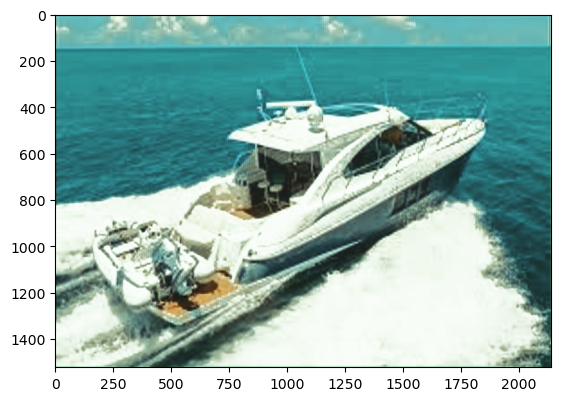

In [11]:
# Draw an anomaly image
im = autoencoder.predict(anomaly_data[:1])
plt.imshow(im[0])

In [12]:
decoded_imgs = autoencoder.predict(x_test_small)
decoded_imgs_anom = autoencoder.predict(anomaly_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


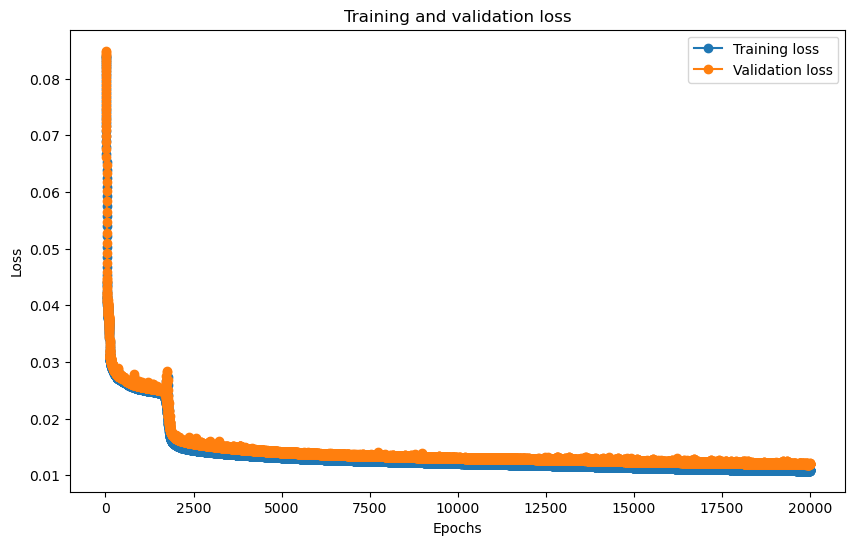

In [13]:
plt.rcParams["figure.figsize"] = (10,6)
loss = a.history['loss']
val_loss = a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '-o', label='Training loss')
plt.plot(epochs, val_loss, '-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The orignal images are:


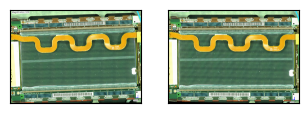


The reconstructed images are:


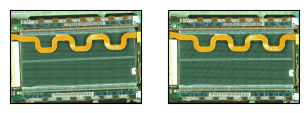

In [16]:
n = 10
plt.figure(figsize=(20, 4))
print("The orignal images are:")
for i in range(0, min(n, len(x_test_small))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_small[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nThe reconstructed images are:")
plt.figure(figsize=(20, 4))
for i in range(0, min(n, len(decoded_imgs))):
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()